# Setup

In [1]:
import os
import pandas as pd
import numpy as np
import re

import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datasets import Dataset

# Statistical Packages
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from numpy.linalg import inv, pinv
from scipy.spatial.distance import cdist, mahalanobis

# Text Analysis
import spacy             # NER
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic
from bert_score import score

# Pure Text Analysis

In [2]:
# Load Transcript Data
df_HoC_gpt = pd.read_csv('/kaggle/input/debate-results/debate_transcript_gpt.csv')
df_HoC_llama_base = pd.read_csv('/kaggle/input/debate-results/debate_transcript_llama_base.csv')
df_HoC_llama_finetuned = pd.read_csv('/kaggle/input/debate-results/debate_transcript_llama_finetuned.csv')
df_HoC_original = pd.read_csv('/kaggle/input/debate-results/debate_transcript_original.csv')

In [3]:
# Merge all Transcript data
df_HoC_gpt['Model'] = 'GPT-3.5'
df_HoC_llama_base['Model'] = 'Llama-3.2 (Base)'
df_HoC_llama_finetuned['Model'] = 'Llama-3.2 (Finetuned)'
df_HoC_original['Model'] = 'Original'

df_HoC_allcombined = pd.concat([df_HoC_gpt, df_HoC_llama_base, df_HoC_llama_finetuned, df_HoC_original], ignore_index=True)
cols = ['Model'] + [col for col in df_HoC_allcombined.columns if col != 'Model']
df_HoC_allcombined = df_HoC_allcombined[cols]
df_HoC_allcombined
df_HoC_allcombined.to_csv('/kaggle/working/debate_transcript_All.csv', index=False)

In [4]:
# Preprocess & remove stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


additional_filler_words = {'said', 'thank', 'would', 'hon.', 'eu'}
stop_words.update(additional_filler_words)

def clean_text(text):
    text = text.lower()    # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)    # Remove punctuation and special characters
    text = re.sub(r'\d+', '', text)    # Remove numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])    # Remove stopwords
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
real_texts = df_HoC_original.iloc[1:]['text'].apply(clean_text).tolist()
gpt_texts = df_HoC_gpt.iloc[1:]['text'].apply(clean_text).tolist()
llamaBase_texts = df_HoC_llama_base.iloc[1:]['text'].apply(clean_text).tolist()
llamaFinetuned_texts = df_HoC_llama_finetuned.iloc[1:]['text'].apply(clean_text).tolist()

## Topic Modeling

In [6]:
embedding_model = SentenceTransformer("all-mpnet-base-v2")  

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
# Generate embeddings
real_embeddings = embedding_model.encode(real_texts, show_progress_bar=True)
gpt_embeddings = embedding_model.encode(gpt_texts, show_progress_bar=True)
llamaBase_embeddings = embedding_model.encode(llamaBase_texts, show_progress_bar=True)
llamaFinetuned_embeddings = embedding_model.encode(llamaFinetuned_texts, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Train BERTopic models
topic_model_real = BERTopic(language="english", min_topic_size=2, n_gram_range=(1, 2))
topics_real, probs_real = topic_model_real.fit_transform(real_texts, real_embeddings)

topic_model_gpt = BERTopic(language="english", min_topic_size=2, n_gram_range=(1, 2))
topics_gpt, probs_gpt = topic_model_gpt.fit_transform(gpt_texts, gpt_embeddings)

topic_model_llamaBase = BERTopic(language="english", min_topic_size=2, n_gram_range=(1, 2))
topics_llamaBase, probs_llamaBase = topic_model_llamaBase.fit_transform(llamaBase_texts, llamaBase_embeddings)

topic_model_llamaFinetuned = BERTopic(language="english", min_topic_size=2, n_gram_range=(1, 2))
topics_llamaFinetuned, probs_llamaFinetuned = topic_model_llamaFinetuned.fit_transform(llamaFinetuned_texts, llamaFinetuned_embeddings)

In [9]:
print(topic_model_real.get_topics())  # Check detected topics
print('\n')
print(topic_model_gpt.get_topics()) 
print('\n')
print(topic_model_llamaBase.get_topics())
print('\n')
print(topic_model_llamaFinetuned.get_topics())

{-1: [('uk', 0.04451751442519855), ('great', 0.029455951433369414), ('currently', 0.029455951433369414), ('hon', 0.028816214172926718), ('movement', 0.028816214172926718), ('changes', 0.02837708512727091), ('leave', 0.027466223773288816), ('academics', 0.026678328103507478), ('union', 0.024293983020025455), ('european union', 0.024293983020025455)], 0: [('government', 0.032727243847945814), ('movement', 0.030827554721346392), ('free', 0.027299118349985944), ('free movement', 0.025202110768904985), ('people', 0.022111363630999567), ('end', 0.020866788281624568), ('uk', 0.02020445582509978), ('generation', 0.01909814845447901), ('least', 0.018398651481074075), ('immigration', 0.018390683736861348)], 1: [('system', 0.053640063009794944), ('status', 0.05098105708345714), ('immigration', 0.04710816347036221), ('immigration system', 0.04673364319620766), ('settled', 0.04485698240911819), ('settled status', 0.04485698240911819), ('stay', 0.03356478294830194), ('next', 0.03180579999778511), ('

**Why does topics = `-1` mean ?**
That would mean that your output shows that BERTopic has only detected a single topic, labeled -1 (outliers/miscellaneous topics) for each dataset. This means that BERTopic did not find distinct, well-separated topics and grouped everything into one general cluster. The barchart visualization will fail because it needs at least two valid topics.

In [10]:
fig1 = topic_model_real.visualize_barchart(top_n_topics=5, title="Real Debate Topics")
fig1.show()

fig2 = topic_model_gpt.visualize_barchart(top_n_topics=5, title="GPT-3.5 Debate Topics")
fig2.show()

fig3 = topic_model_llamaBase.visualize_barchart(top_n_topics=5, title="Llama-3.2 (Base) Debate Topics")
fig3.show()

fig4 = topic_model_llamaFinetuned.visualize_barchart(top_n_topics=5, title="Llama-3.2 (Finetuned) Debate Topics")
fig4.show()

## Semantic Similarity: Sentence Embeddings

In [11]:
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
real_texts_joined = " ".join(real_texts)
gpt_texts_joined = " ".join(gpt_texts)
llamaBase_texts_joined = " ".join(llamaBase_texts)
llamaFinetuned_texts_joined = " ".join(llamaFinetuned_texts)

real_embedding = embedding_model.encode(real_texts_joined, convert_to_tensor=True)
gpt_embedding = embedding_model.encode(gpt_texts_joined, convert_to_tensor=True)
llamaBase_embedding = embedding_model.encode(llamaBase_texts_joined, convert_to_tensor=True)
llamaFinetuned_embedding = embedding_model.encode(llamaFinetuned_texts_joined, convert_to_tensor=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
# Compute cosine similarity between the two embeddings
gpt_similarity = util.cos_sim(real_embedding, gpt_embedding)
llamaBase_similarity = util.cos_sim(real_embedding, llamaBase_embedding)
llamaFinetuned_similarity = util.cos_sim(real_embedding, llamaFinetuned_embedding)

print("GPT similarity:", gpt_similarity.item())
print("Llama Base similarity:", llamaBase_similarity.item())
print("Llama Finetuned similarity:", llamaFinetuned_similarity.item())

GPT similarity: 0.8253337144851685
Llama Base similarity: 0.75542151927948
Llama Finetuned similarity: 0.866952657699585


## Semantic Similarity: BERTScore

In [14]:
candidates = [gpt_texts_joined, llamaBase_texts_joined, llamaFinetuned_texts_joined]
references = [real_texts_joined, real_texts_joined, real_texts_joined]

# Compute BERTScore for each candidate
P, R, F1 = score(candidates, references, lang="en", verbose=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.58 seconds, 5.18 sentences/sec


In [15]:
print("GPT BERTScore F1:", F1[0].item())
print("Llama Base BERTScore F1:", F1[1].item())
print("Llama Finetuned BERTScore F1:", F1[2].item())

GPT BERTScore F1: 0.7816446423530579
Llama Base BERTScore F1: 0.790835440158844
Llama Finetuned BERTScore F1: 0.8040645122528076


## Named Entity Recognition (NER)

In [16]:
nlp = spacy.load("en_core_web_sm")

# Function to extract named entities
def extract_named_entities(texts):
    entities = []
    for text in texts:
        doc = nlp(text)
        entities.extend([ent.text for ent in doc.ents])
    return entities

In [17]:
# Extract named entities from each dataset
real_entities = extract_named_entities(real_texts)
gpt_entities = extract_named_entities(gpt_texts)
llamaBase_entities = extract_named_entities(llamaBase_texts)
llamaFinetuned_entities = extract_named_entities(llamaFinetuned_texts)

# Convert to sets for comparison
real_entities_set = set(real_entities)
gpt_entities_set = set(gpt_entities)
llamaBase_entities_set = set(llamaBase_entities)
llamaFinetuned_entities_set = set(llamaFinetuned_entities)

In [18]:
# Compute overlaps
gpt_entity_overlap = len(real_entities_set.intersection(gpt_entities_set)) / len(real_entities_set)
llamaBase_entity_overlap = len(real_entities_set.intersection(llamaBase_entities_set)) / len(real_entities_set)
llamaFinetuned_entity_overlap = len(real_entities_set.intersection(llamaFinetuned_entities_set)) / len(real_entities_set)

print(f"NER Overlap - GPT-3.5: {gpt_entity_overlap:.5}")
print(f"NER Overlap - Llama-3.2-Base: {llamaBase_entity_overlap:.5%}")
print(f"NER Overlap - Llama-3.2-Finetuned: {llamaFinetuned_entity_overlap:.5%}")

NER Overlap - GPT-3.5: 0.017857
NER Overlap - Llama-3.2-Base: 10.71429%
NER Overlap - Llama-3.2-Finetuned: 10.71429%


# LSM Results

In [19]:
color_palette = {
    "Original Text": "#1f77b4",  # Blue
    "Gpt 3.5 Text": "#ff7f0e",   # Orange
    "Llama 3.2 Text (Base)": "#2ca02c",  # Green
    "Llama 3.2 Text (Finetuned)": "#d62728"  # Red
}

sns.set(style="whitegrid")

## LSM - Overview

In [20]:
# Load LSM Analysis DF and Process
LSM_analysis_heatmap = pd.read_csv('/kaggle/input/debate-results/LSM_debate_results_Overall.csv')

LSM_analysis_heatmap = LSM_analysis_heatmap.rename(columns={'1': 'Gpt 3.5 Text',   '2': 'Llama 3.2 Text (Base)',   '3': 'Llama 3.2 Text (Finetuned)' })
LSM_analysis_heatmap["Filename"] = LSM_analysis_heatmap["Filename"].replace({
    "debate_transcript_original.txt": "Original Text",
    "debate_transcript_gpt.txt": "Gpt 3.5 Text",
    "debate_transcript_llama_base.txt": "Llama 3.2 Text (Base)",
    "debate_transcript_llama_finetuned.txt": "Llama 3.2 Text (Finetuned)",})
LSM_analysis_heatmap = LSM_analysis_heatmap.drop(index=[0, 1, 2], columns=['Document number'])
LSM_analysis_heatmap.set_index('Filename', inplace=True)

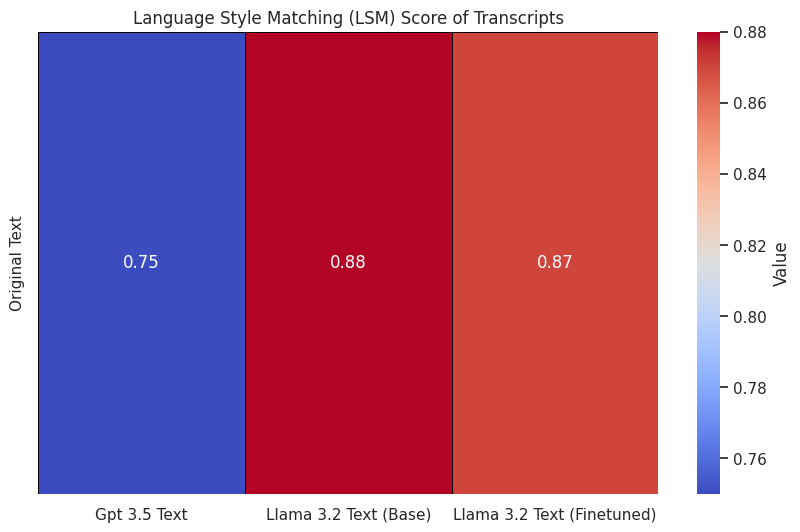

In [21]:
# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(LSM_analysis_heatmap.iloc[:, 0:], 
            annot=True, cmap='coolwarm', 
            cbar_kws={'label': 'Value'}, 
            linewidths=0.5, linecolor='black')
plt.title('Language Style Matching (LSM) Score of Transcripts')
plt.xlabel('')
plt.ylabel('')

plt.savefig('/kaggle/working/LSM_comparison_Model.png')
plt.show()

## LSM - Speaker Level

In [22]:
# Load LSM Analysis DF and Process
LSM_analysis = pd.read_csv('/kaggle/input/debate-results/LSM_debate_results_Speakers.csv')

# Preprocess LSM Results
LSM_analysis["GroupID"] = LSM_analysis["GroupID"].replace({
    "debate_transcript_original.txt": "Original Text",
    "debate_transcript_gpt.txt": "Gpt 3.5 Text",
    "debate_transcript_llama_base.txt": "Llama 3.2 Text (Base)",
    "debate_transcript_llama_finetuned.txt": "Llama 3.2 Text (Finetuned)",})

speaker_to_party = df_HoC_original.set_index('speaker')['party'].to_dict()

LSM_analysis['GroupID'] = LSM_analysis['GroupID'].str.replace('debate_transcript_', '')
LSM_analysis['Person.1'] = LSM_analysis['Person.1'].str.replace(':', '')
LSM_analysis['Person.2'] = LSM_analysis['Person.2'].str.replace(':', '')

LSM_analysis['party_speaker1'] = LSM_analysis['Person.1'].map(speaker_to_party)
LSM_analysis['party_speaker2'] = LSM_analysis['Person.2'].map(speaker_to_party)

LSM_analysis['party_pair'] = LSM_analysis.apply(lambda row: '-'.join(sorted([row['party_speaker1'], row['party_speaker2']])), axis=1)
LSM_analysis['same_party'] = LSM_analysis.apply(lambda row: 'Same Party' if row['party_speaker1'] == row['party_speaker2'] else 'Different Party', axis=1)

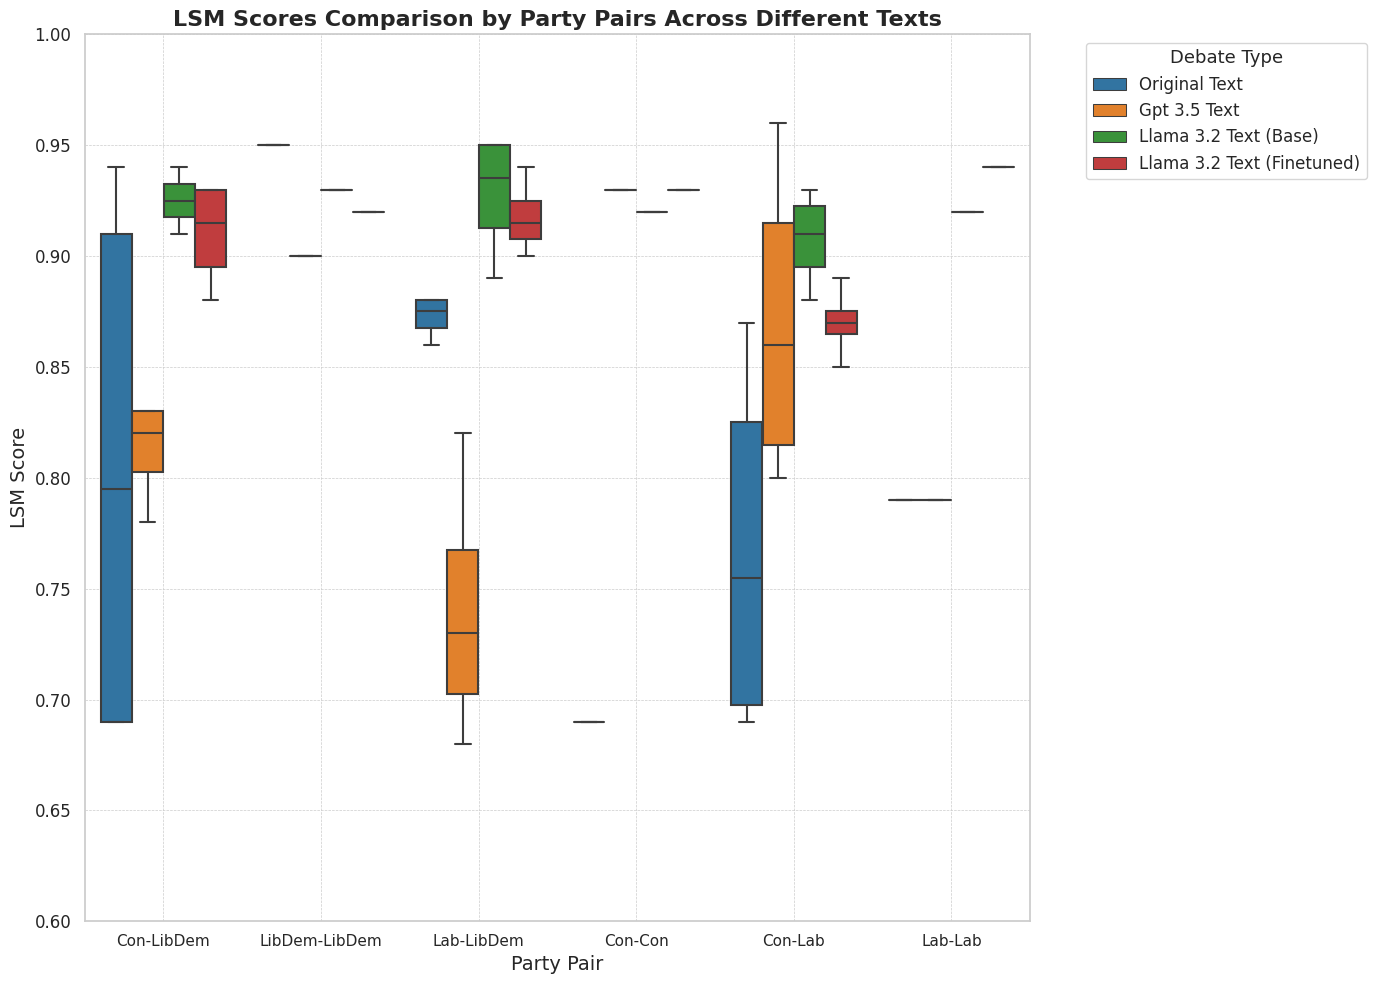

In [23]:
plt.figure(figsize=(14, 10))
boxplot = sns.boxplot(x='party_pair', y='LSM', 
                      hue='GroupID', 
                      data=LSM_analysis, palette=color_palette)
plt.title('LSM Scores Comparison by Party Pairs Across Different Texts', fontsize=16, weight='bold')
plt.xlabel('Party Pair', fontsize=14)
plt.ylabel('LSM Score', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(title='Debate Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize='13')
plt.ylim(0.6, 1)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('/kaggle/working/LSM_comparison_PartyPair_v1.png', dpi=300)
plt.show()

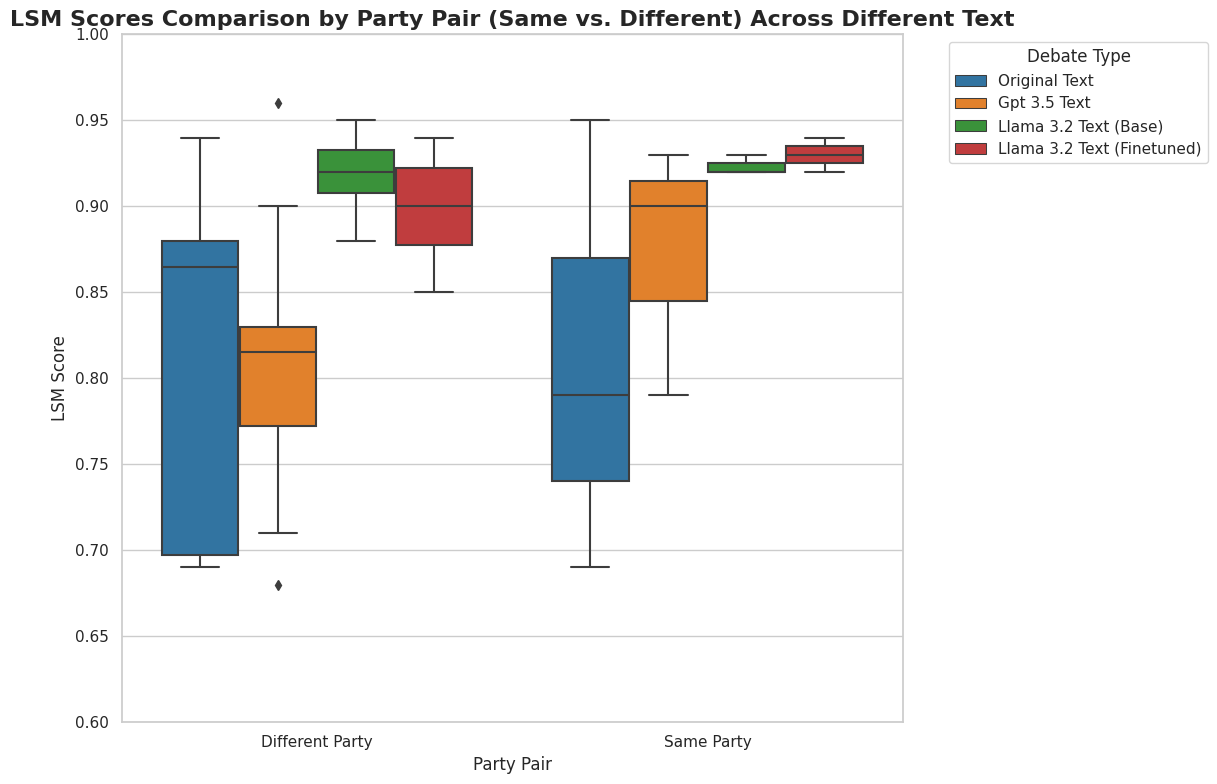

In [24]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='same_party', y='LSM', hue='GroupID', 
            data=LSM_analysis, palette=color_palette)
plt.title('LSM Scores Comparison by Party Pair (Same vs. Different) Across Different Text', fontsize=16, weight='bold')
plt.xlabel('Party Pair')
#plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('LSM Score')
plt.legend(title='Debate Type', 
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0.6,1)
plt.tight_layout()
plt.savefig('/kaggle/working/LSM_comparison_PartyPair_v2.png', dpi=300)
plt.show()

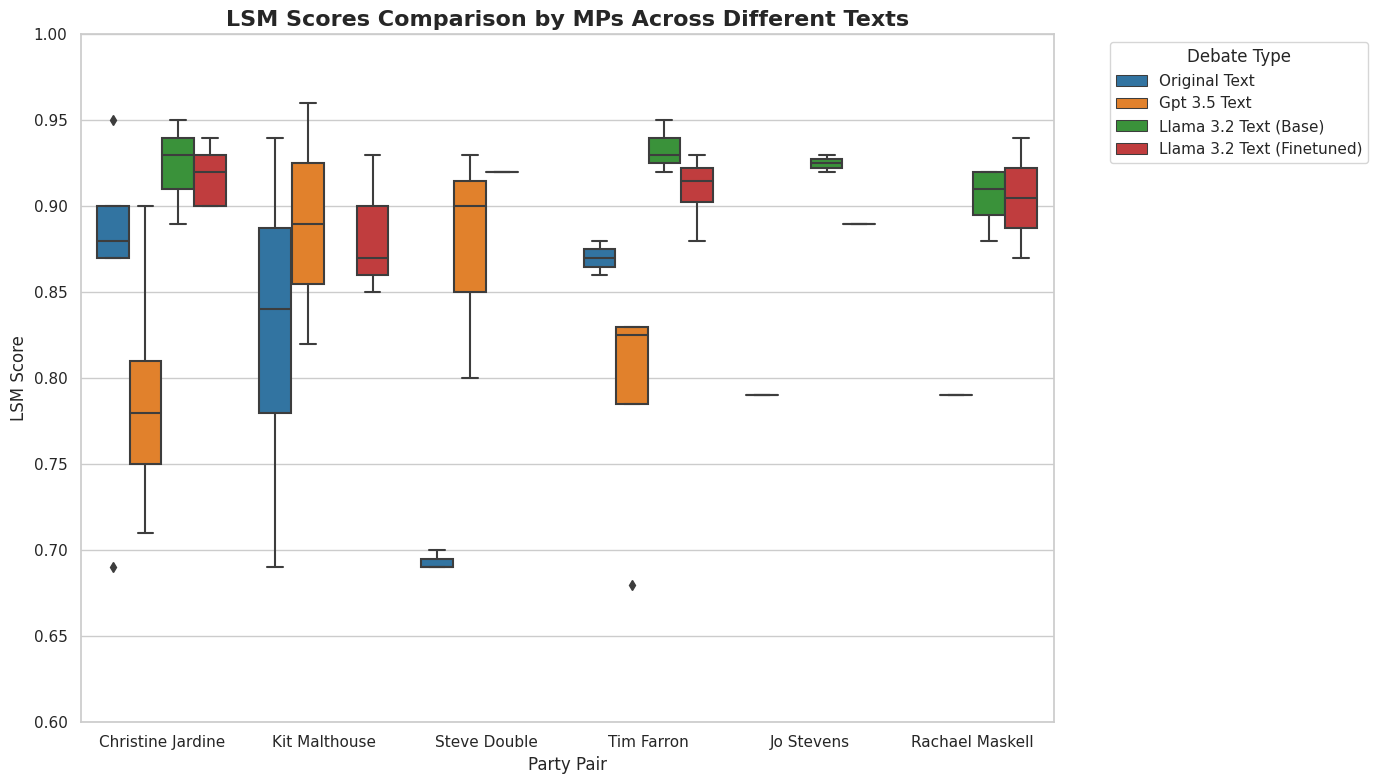

In [25]:
# Plot box plot comparison
plt.figure(figsize=(14, 8))
sns.boxplot(x='Person.1', y='LSM',hue='GroupID', 
            data=LSM_analysis, palette=color_palette)
plt.title('LSM Scores Comparison by MPs Across Different Texts', fontsize=16, weight='bold')
plt.xlabel('Party Pair')
plt.ylabel('LSM Score')
plt.legend(title='Debate Type', 
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0.6,1)
plt.tight_layout()
plt.savefig('/kaggle/working/LSM_comparison_Speakers.png', dpi=300)
plt.show()

## LSM - Time Variation

In [26]:
LSM_analysis_Segmented = pd.read_csv('/kaggle/input/debate-results/LSM_debate_results_Speakers_segmented.csv')

# Preprocess
speaker_to_party = df_HoC_original.set_index('speaker')['party'].to_dict()
LSM_analysis_Segmented['Person.1'] = LSM_analysis_Segmented['Person.1'].str.replace(':', '')
LSM_analysis_Segmented['Person.2'] = LSM_analysis_Segmented['Person.2'].str.replace(':', '')
LSM_analysis_Segmented["GroupID"] = LSM_analysis_Segmented["GroupID"].replace({
    "Original": "Original Text",
    "GPT-3.5": "Gpt 3.5 Text",
    "Llama-3.2 (Base)": "Llama 3.2 Text (Base)",
    "Llama-3.2 (Finetuned)": "Llama 3.2 Text (Finetuned)",})

LSM_analysis_Segmented['party_speaker1'] = LSM_analysis_Segmented['Person.1'].map(speaker_to_party)
LSM_analysis_Segmented['party_speaker2'] = LSM_analysis_Segmented['Person.2'].map(speaker_to_party)
LSM_analysis_Segmented['speaker_pair'] = LSM_analysis_Segmented.apply(lambda row: '-'.join(sorted([row['Person.1'], row['Person.2']])), axis=1)

LSM_analysis_Segmented['party_pair'] = LSM_analysis_Segmented.apply(lambda row: '-'.join(sorted([row['party_speaker1'], row['party_speaker2']])), axis=1)
LSM_analysis_Segmented['same_party'] = LSM_analysis_Segmented.apply(lambda row: 'Same Party' if row['party_speaker1'] == row['party_speaker2'] else 'Different Party', axis=1)
LSM_analysis_Segmented.head(3)

,GroupID,Segment,Person.1,Person.2,LSM,WC.Person.1,WC.Person.2,party_speaker1,party_speaker2,speaker_pair,party_pair,same_party
0,Gpt 3.5 Text,1,Christine Jardine,Tim Farron,0.86,325,203,LibDem,LibDem,Christine Jardine-Tim Farron,LibDem-LibDem,Same Party
1,Gpt 3.5 Text,1,Christine Jardine,Steve Double,0.79,325,183,LibDem,Con,Christine Jardine-Steve Double,Con-LibDem,Different Party
2,Gpt 3.5 Text,1,Christine Jardine,Kit Malthouse,0.72,325,189,LibDem,Con,Christine Jardine-Kit Malthouse,Con-LibDem,Different Party


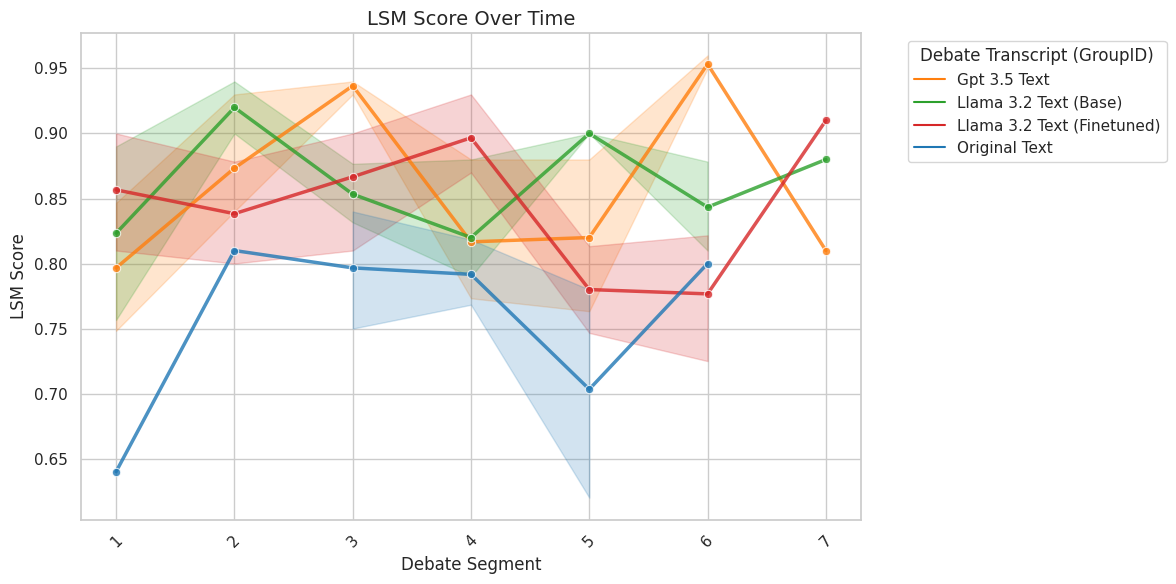

In [27]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=LSM_analysis_Segmented, palette=color_palette,
             x="Segment", 
             y="LSM", 
             hue="GroupID", 
             marker="o", linewidth=2.5, alpha=0.8,ci=95 )
plt.title("LSM Score Over Time", fontsize=14)
plt.xlabel("Debate Segment", fontsize=12)
plt.ylabel("LSM Score", fontsize=12)
plt.legend(title="Debate Transcript (GroupID)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/kaggle/working/LSM_variations_over_Time.png', dpi=300)
plt.show()

# LIWC Results

In [28]:
liwc_categories = {
    "Summary Variables": ['Analytic', 'Clout', 'Authentic', 
                          'Tone', 'WPS', 'BigWords', 'Dic'],
    "Linguistic Dimensions": ['Linguistic', 'function', 'pronoun', 'ppron', 'ipron', 'det', 
                              'article', 'number', 'prep', 'auxverb', 'adverb', 'conj', 
                              'negate', 'verb', 'adj', 'quantity'],
    "Psychological Processes": ['Drives', 'affiliation', 'achieve', 'power', 'Cognition', 
                                'allnone', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 
                                'certitude', 'differ', 'memory', 'Affect', 'tone_pos', 'tone_neg', 
                                'emoti,on', 'emo_pos', 'emo_neg', 'emo,anx', 'emo_anger', 'emo,sad', 
                                'socbehav', 'pro,social', 'polite', 'confl,ict', 'moral', 'soc,refs', 
                                'family', 'friend', 'female', 'male'],
    'Culture': ['Culture', 'politic', 'ethnicity', 'tech'],
    'Lifestyle': ['lifestyle', 'leisure', 'home', 'work', 'money', 'relig'],
    'Physical': ['physical', 'health', 'illness', 'wellness', 'mental', 'substances', 'sexual', 'food', 'death'],
    'States': ['need', 'want', 'acquire', 'lack', 'fulfill', 'fatigue'],
    'Motives': ['reward', 'risk', 'curiosity', 'allure'],
    'Perception': ['Perception', 'attention', 'motion', 'space', 'visual', 'auditory', 'feeling']
}

## LIWC Analysis - Time Variation

In [29]:
df_LIWCresults_Segmented = pd.read_csv('/kaggle/input/debate-results/LIWC_analysis_debate_all_Models_segmented.csv')
df_LIWCresults_Segmented["Filename"] = df_LIWCresults_Segmented["Filename"].replace({
    "debate_transcript_original.txt": "Original Text",
    "debate_transcript_gpt.txt": "Gpt 3.5 Text",
    "debate_transcript_llama_base.txt": "Llama 3.2 Text (Base)",
    "debate_transcript_llama_finetuned.txt": "Llama 3.2 Text (Finetuned)",})

In [30]:
liwc_metrics = df_LIWCresults_Segmented.columns[3:11]
liwc_metrics

Index(['Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'BigWords', 'Dic',
       'Linguistic'],
      dtype='object')

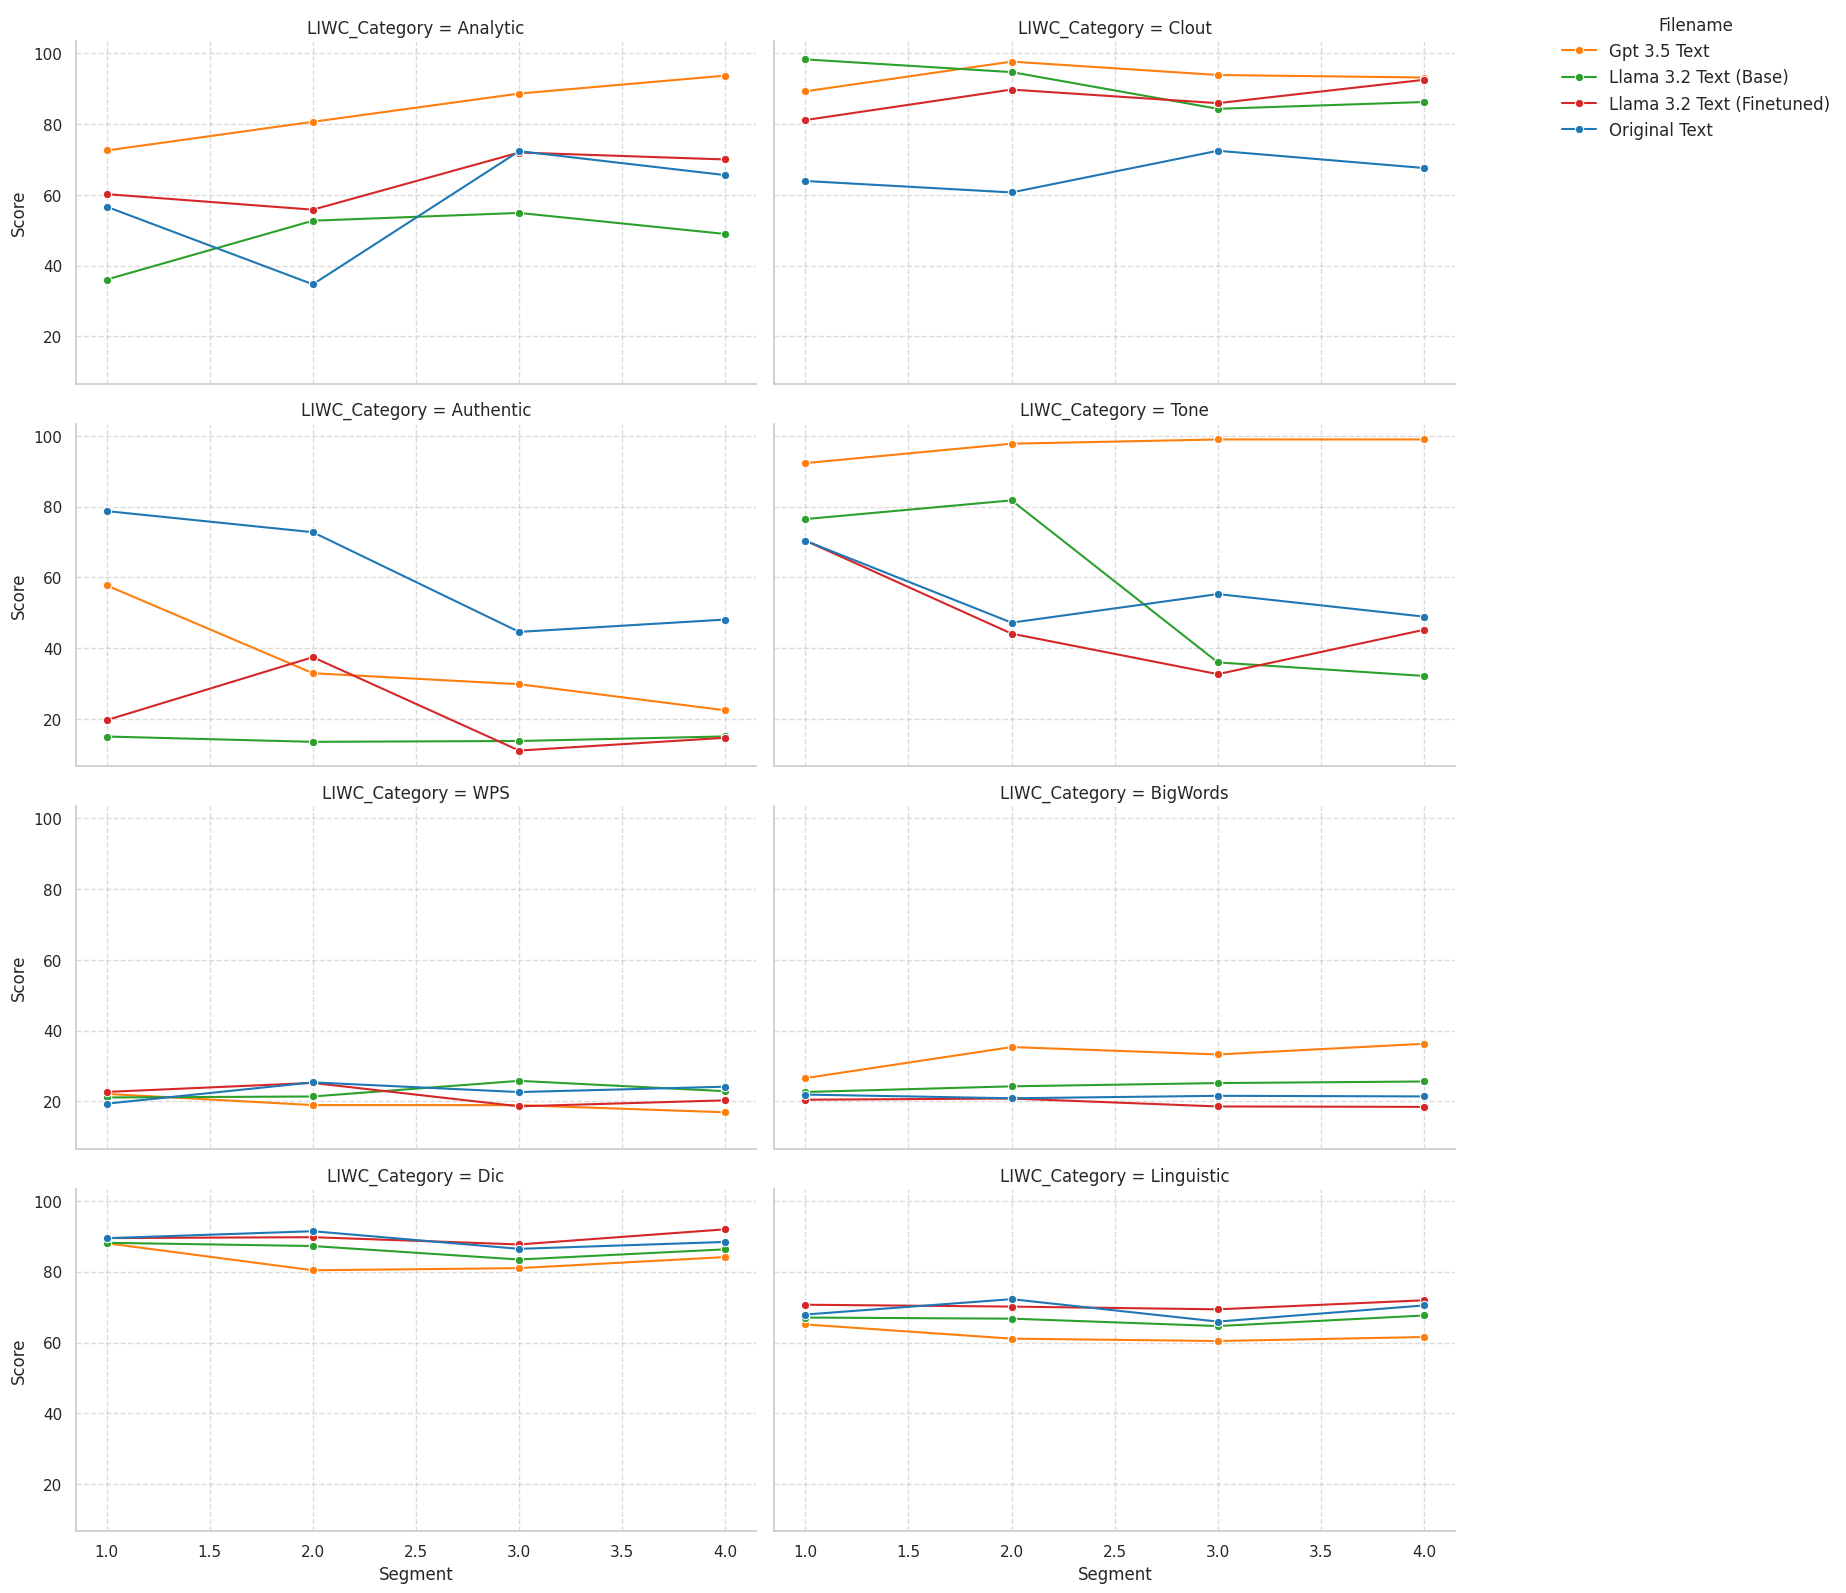

In [31]:
df_melted = df_LIWCresults_Segmented.melt(
    id_vars=["Filename", "Segment"],
    value_vars=liwc_metrics,
    var_name="LIWC_Category",
    value_name="Score")

# Create a FacetGrid with each LIWC category in a separate panel
g = sns.FacetGrid(df_melted, col="LIWC_Category", hue="Filename", palette=color_palette, col_wrap=2, height=4, aspect=1.5)
g.map(sns.lineplot, "Segment", "Score", marker="o")
g.add_legend(title="Filename", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize='13')

# Add gridlines
for ax in g.axes.flatten():
    ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig('/kaggle/working/LIWC_variations_over_Time.png')
plt.show()


## LIWC Analysis - Individual Agent

In [32]:
# Load LIWC Results
df_LIWCresults_Speakers = pd.read_csv('/kaggle/input/debate-results/LIWC_analysis_debate_all_transcript_Speakers.csv')

# Clean df_LIWCresults_Speakers
df_LIWCresults_Speakers['Speaker'] = df_LIWCresults_Speakers['Speaker'].str.replace(':', '')
df_LIWCresults_Speakers["TextID"] = df_LIWCresults_Speakers["TextID"].replace({
    "debate_transcript_original.txt": "Original Text",
    "debate_transcript_gpt.txt": "Gpt 3.5 Text",
    "debate_transcript_llama_base.txt": "Llama 3.2 Text (Base)",
    "debate_transcript_llama_finetuned.txt": "Llama 3.2 Text (Finetuned)",
})
#df_LIWCresults_Speakers = df_LIWCresults_Speakers.loc[:, (df_LIWCresults_Speakers != 0).any(axis=0)] # Remove columns with ALL 0
df_LIWCresults_Speakers.head()

,TextID,Speaker,Text,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,Gpt 3.5 Text,Christine Jardine,"I beg to move, That this House has considered ...",1,829,74.58,95.10,50.69,98.61,20.22,...,0,0,12.42,4.58,5.67,0.48,0.0,0.72,0.97,0
1,Gpt 3.5 Text,Tim Farron,"Thank you, Christine Jardine, for bringing thi...",1,608,86.56,92.74,35.81,99.00,18.42,...,0,0,11.84,5.43,4.28,0.00,0.0,0.66,1.48,0
2,Gpt 3.5 Text,Steve Double,Thank you for bringing up this important issue...,1,382,83.09,90.07,38.37,99.00,21.22,...,0,0,10.99,4.71,2.62,0.00,0.0,2.09,1.57,0
3,Gpt 3.5 Text,Kit Malthouse,Thank you for bringing up this important issue...,1,717,88.33,95.34,33.42,99.00,19.38,...,0,0,9.76,5.16,2.79,0.00,0.0,0.70,1.12,0
4,Gpt 3.5 Text,Rachael Maskell,Thank you for bringing this important issue to...,1,79,80.82,99.00,29.73,99.00,15.80,...,0,0,12.66,6.33,3.80,0.00,0.0,1.27,1.27,0


In [33]:
# Preview the list of LIWC categories
print("LIWC Results columns:")
print(df_LIWCresults_Speakers.columns)#[2:]
      
# Select the LIWC Features/Category 
liwc_features = df_LIWCresults_Speakers.loc[:, 'Analytic':'OtherP'].columns
print("\n\nLIWC Main Features")
print(liwc_features)

LIWC Results columns:
Index(['TextID', 'Speaker', 'Text', 'Segment', 'WC', 'Analytic', 'Clout',
       'Authentic', 'Tone', 'WPS',
       ...
       'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'QMark', 'Exclam',
       'Apostro', 'OtherP', 'Emoji'],
      dtype='object', length=122)


LIWC Main Features
Index(['Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'BigWords', 'Dic',
       'Linguistic', 'function', 'pronoun',
       ...
       'assent', 'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'QMark',
       'Exclam', 'Apostro', 'OtherP'],
      dtype='object', length=116)


In [34]:
# Create Individual Agent subsets
df_LIWCresults_Kit_Malthouse = df_LIWCresults_Speakers[df_LIWCresults_Speakers['Speaker'] == 'Kit Malthouse']
df_LIWCresults_Rachael_Maskell = df_LIWCresults_Speakers[df_LIWCresults_Speakers['Speaker'] == 'Rachael Maskell']
df_LIWCresults_Steve_Double = df_LIWCresults_Speakers[df_LIWCresults_Speakers['Speaker'] == 'Steve Double']
df_LIWCresults_Tim_Farron = df_LIWCresults_Speakers[df_LIWCresults_Speakers['Speaker'] == 'Tim Farron']
df_LIWCresults_Christine_Jardine = df_LIWCresults_Speakers[df_LIWCresults_Speakers['Speaker'] == 'Christine Jardine']
df_LIWCresults_Jo_Stevens = df_LIWCresults_Speakers[df_LIWCresults_Speakers['Speaker'] == 'Jo Stevens']

# preview an example:
df_LIWCresults_Kit_Malthouse

,TextID,Speaker,Text,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
3,Gpt 3.5 Text,Kit Malthouse,Thank you for bringing up this important issue...,1,717,88.33,95.34,33.42,99.00,19.38,...,0,0,9.76,5.16,2.79,0.0,0.0,0.70,1.12,0
11,Llama 3.2 Text (Base),Kit Malthouse,"""Thank you, Tim, for your thoughtful and nuanc...",1,1211,47.63,87.57,14.21,49.25,22.43,...,0,0,18.50,4.46,5.37,0.0,0.0,5.12,3.55,0
14,Llama 3.2 Text (Finetuned),Kit Malthouse,I rise to respond to my hon. Friend's impassio...,1,1062,57.33,94.57,12.81,39.42,22.13,...,0,0,10.73,4.52,4.80,0.0,0.0,0.94,0.47,0
19,Original Text,Kit Malthouse,That is not correct.\r\nThank you for presidin...,1,1830,70.65,71.07,51.75,53.23,23.16,...,0,0,11.31,4.59,5.03,0.0,0.0,0.33,1.37,0


In [35]:
df_subsets = {
    "Kit_Malthouse": df_LIWCresults_Kit_Malthouse,
    "Rachael_Maskell": df_LIWCresults_Rachael_Maskell,
    "Steve_Double": df_LIWCresults_Steve_Double,
    "Tim_Farron": df_LIWCresults_Tim_Farron,
    "Christine_Jardine": df_LIWCresults_Christine_Jardine,
    "Jo_Stevens": df_LIWCresults_Jo_Stevens
}

### Cosine Similarity

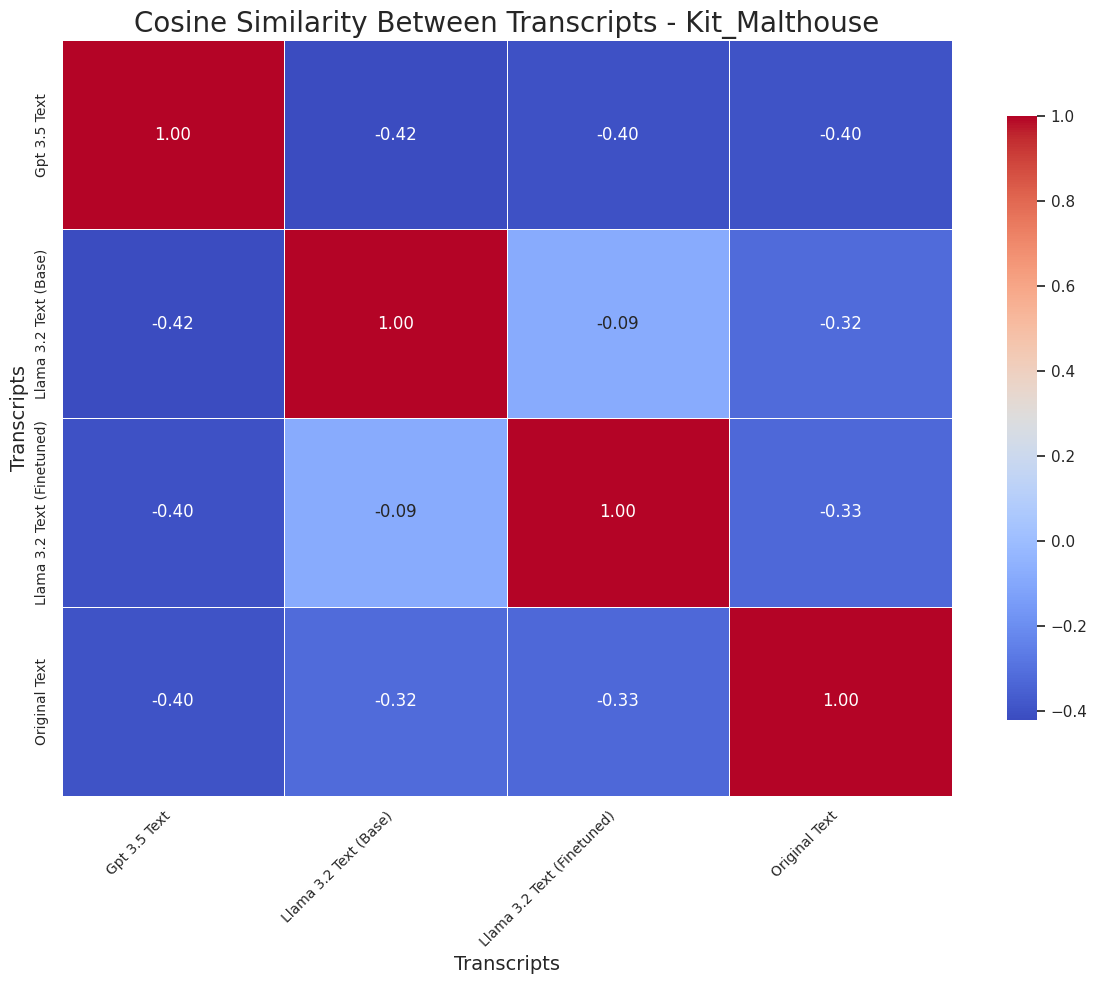

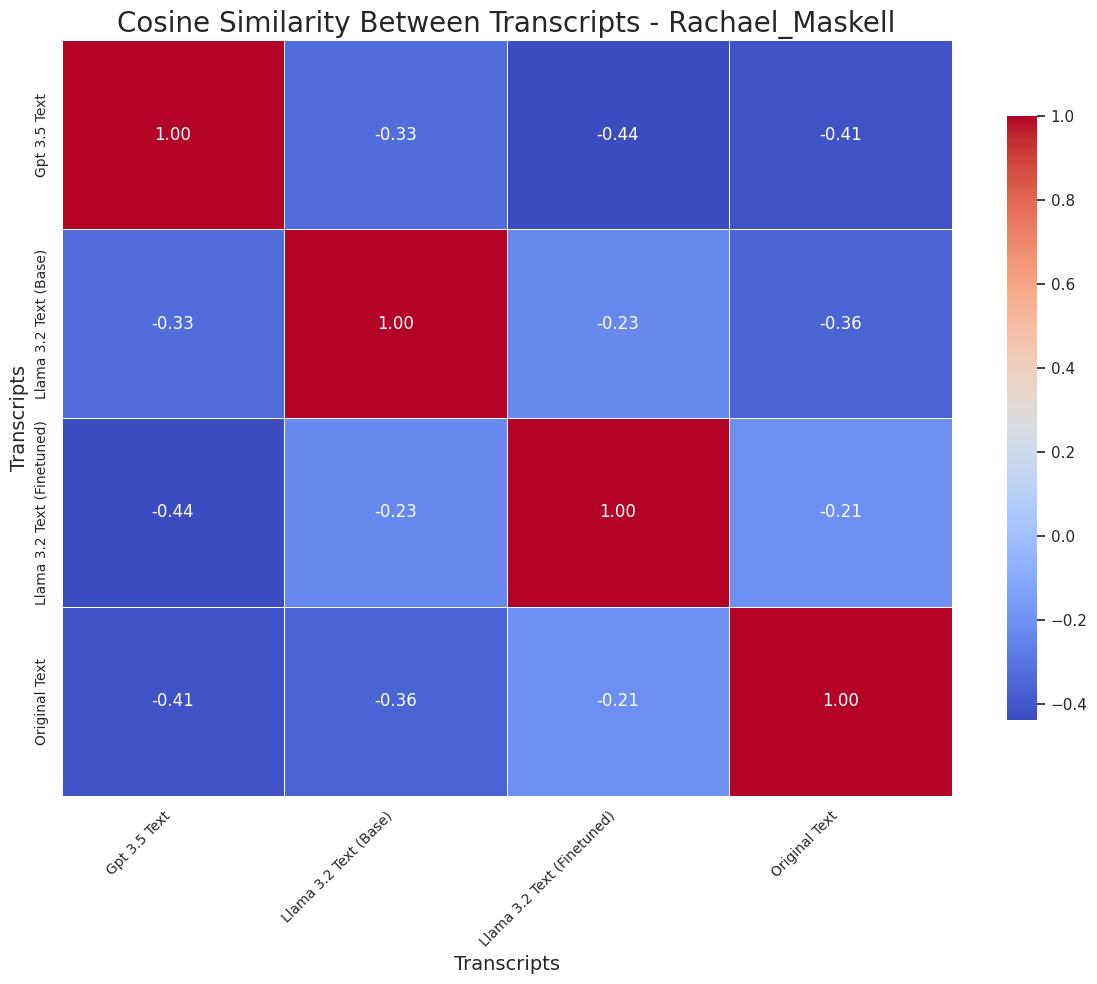

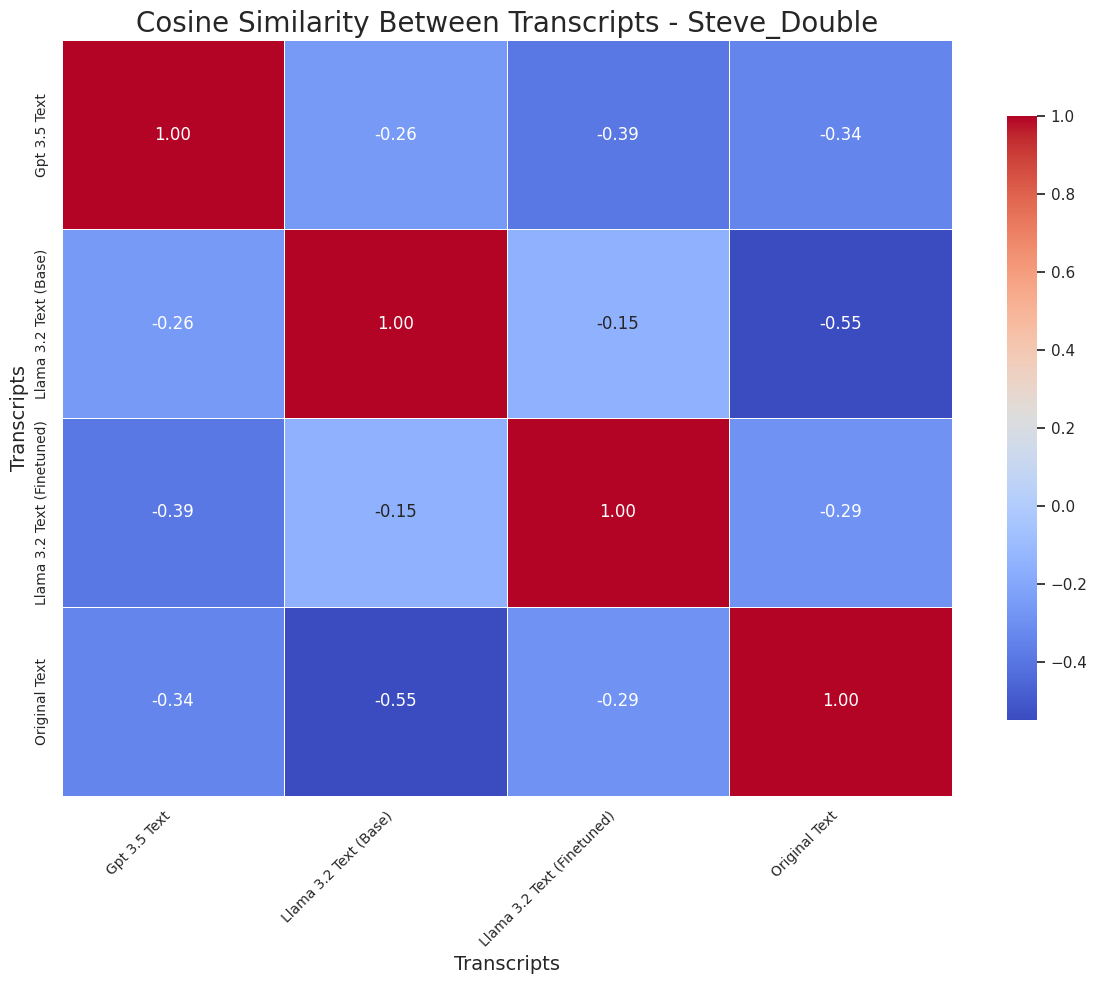

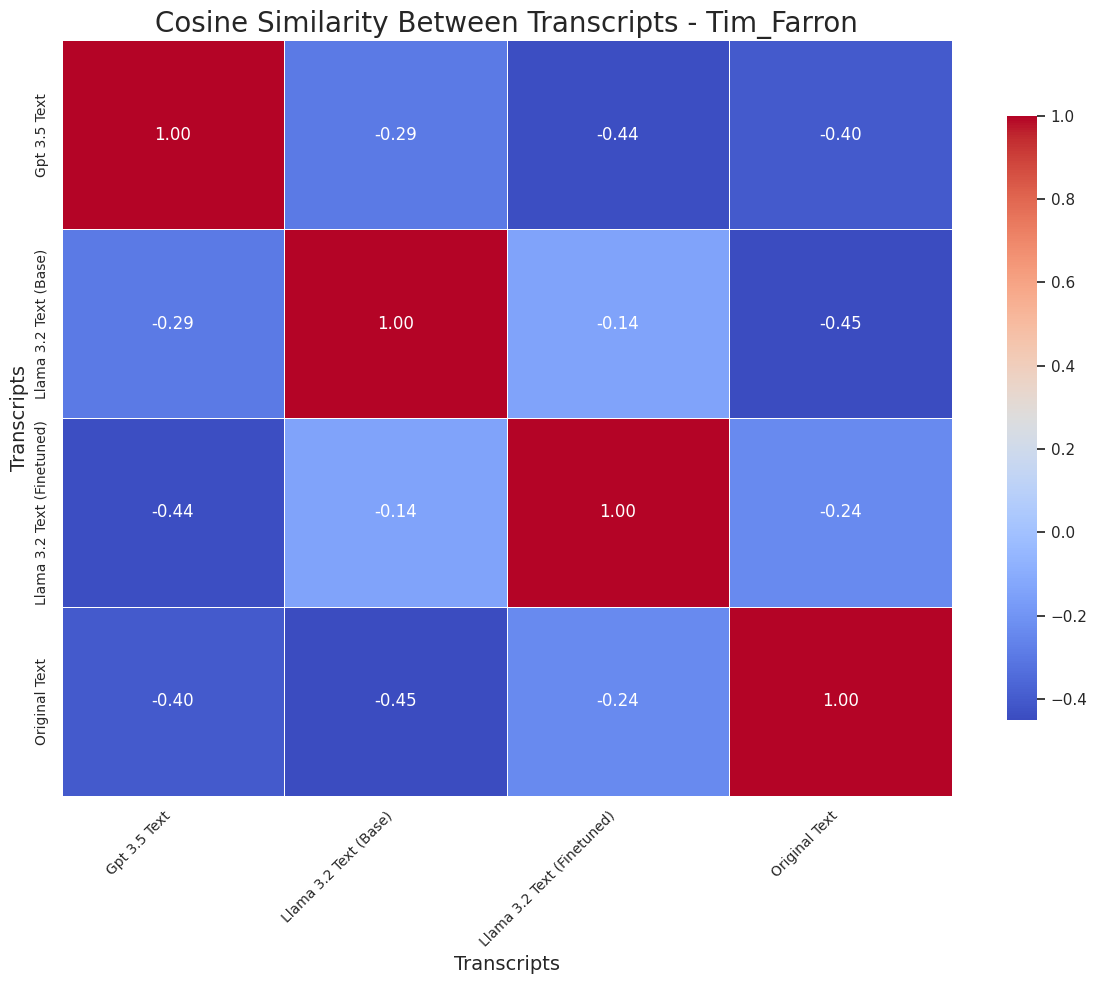

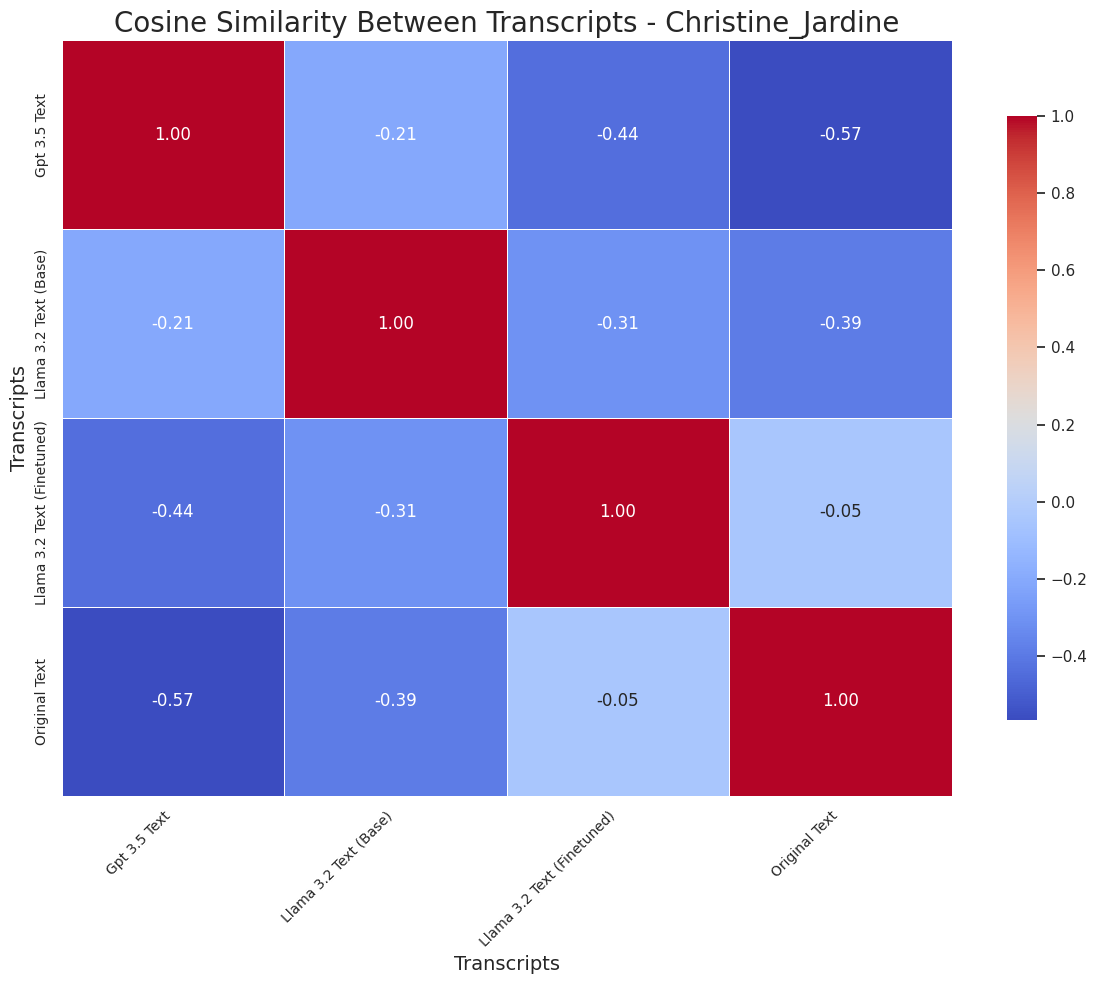

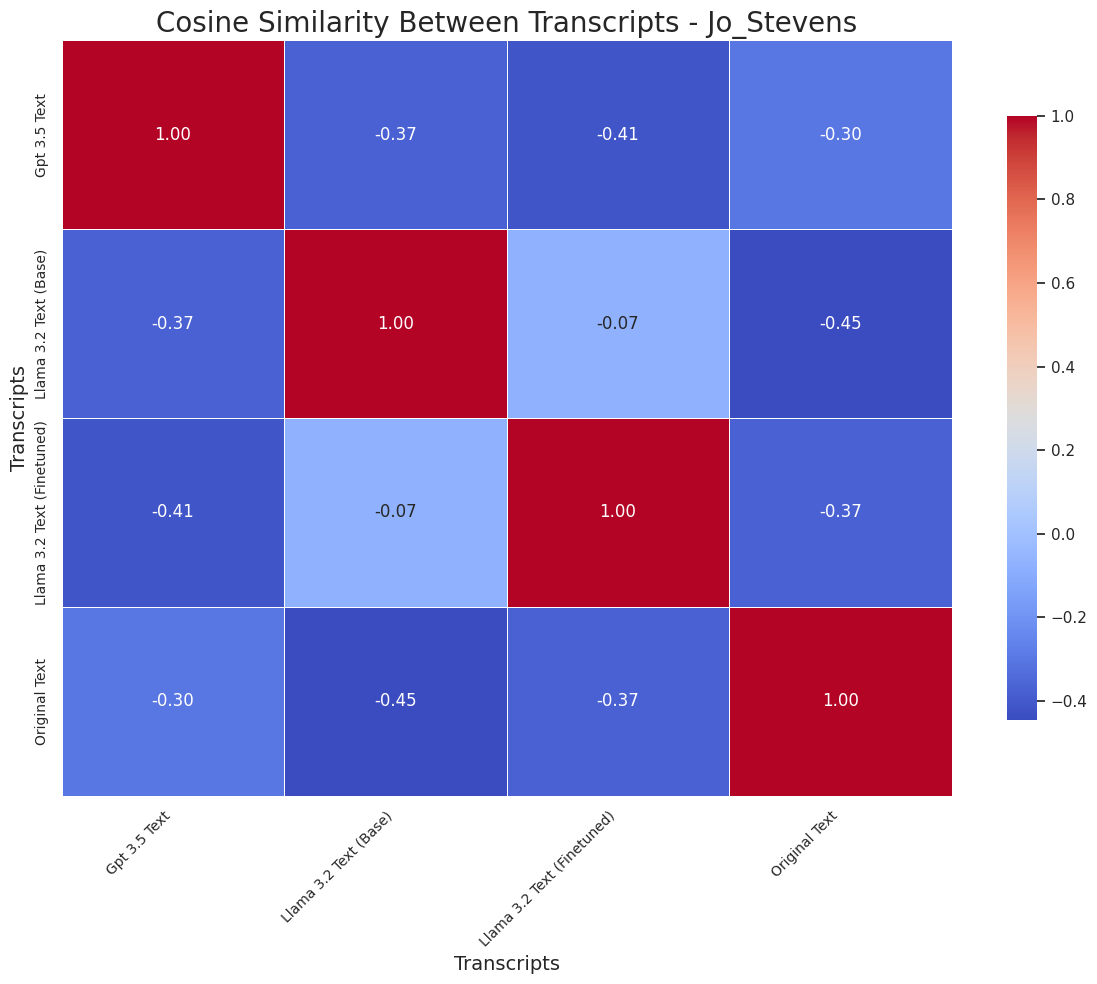

In [36]:
for speaker, df_subset in df_subsets.items():

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_subset[liwc_features])
    
    cosine_sim_matrix = cosine_similarity(df_scaled)

    plt.figure(figsize=(12, 10))    # Plot the heatmap
    sns.heatmap(cosine_sim_matrix, 
                annot=True, 
                fmt=".2f", 
                cmap='coolwarm', 
                xticklabels=df_subset['TextID'], 
                yticklabels=df_subset['TextID'], 
                linewidths=.5, 
                cbar_kws={"shrink": .8})
    plt.title(f'Cosine Similarity Between Transcripts - {speaker}', fontsize=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Transcripts', fontsize=14)
    plt.ylabel('Transcripts', fontsize=14)
    plt.tight_layout()

    plt.savefig(f'/kaggle/working/cosine_similarity_{speaker}.png')
    plt.show()

### Mahalanobis Distance

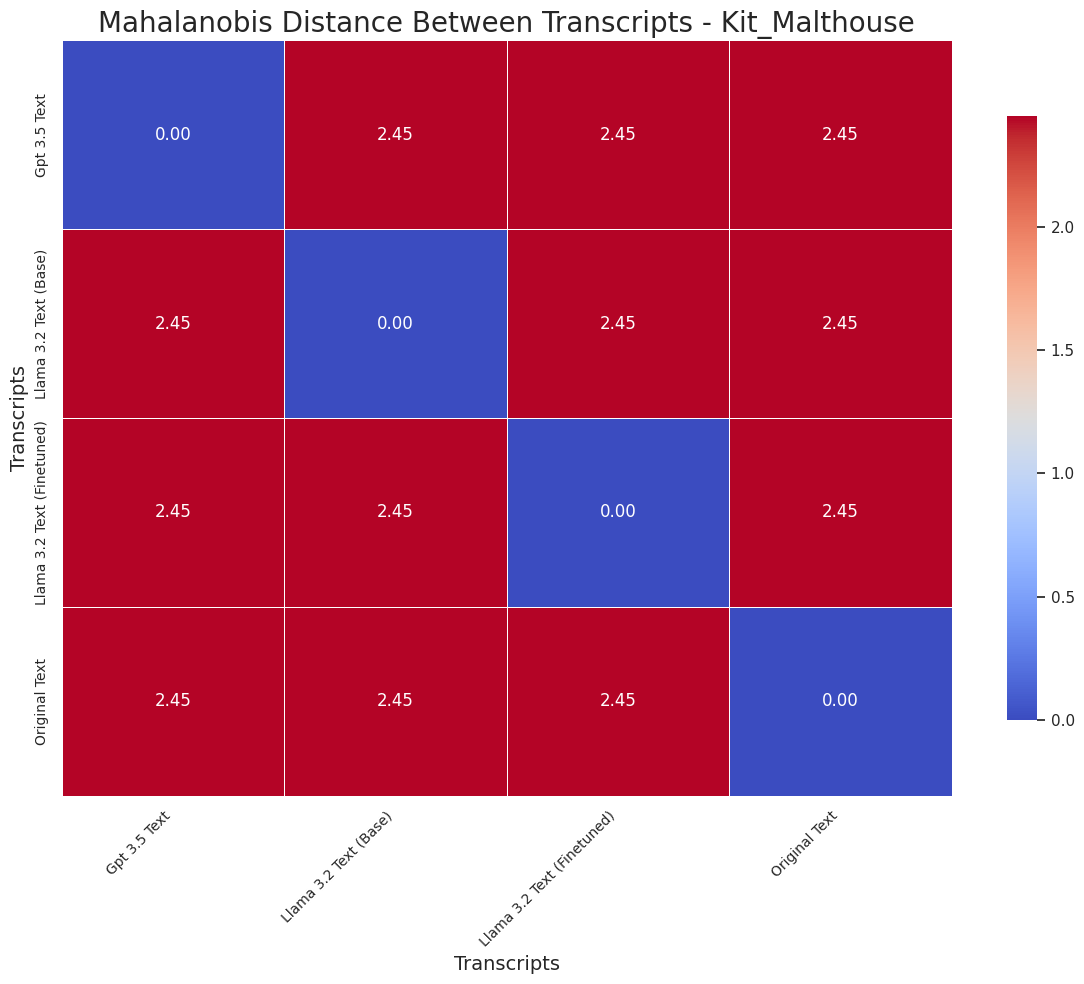

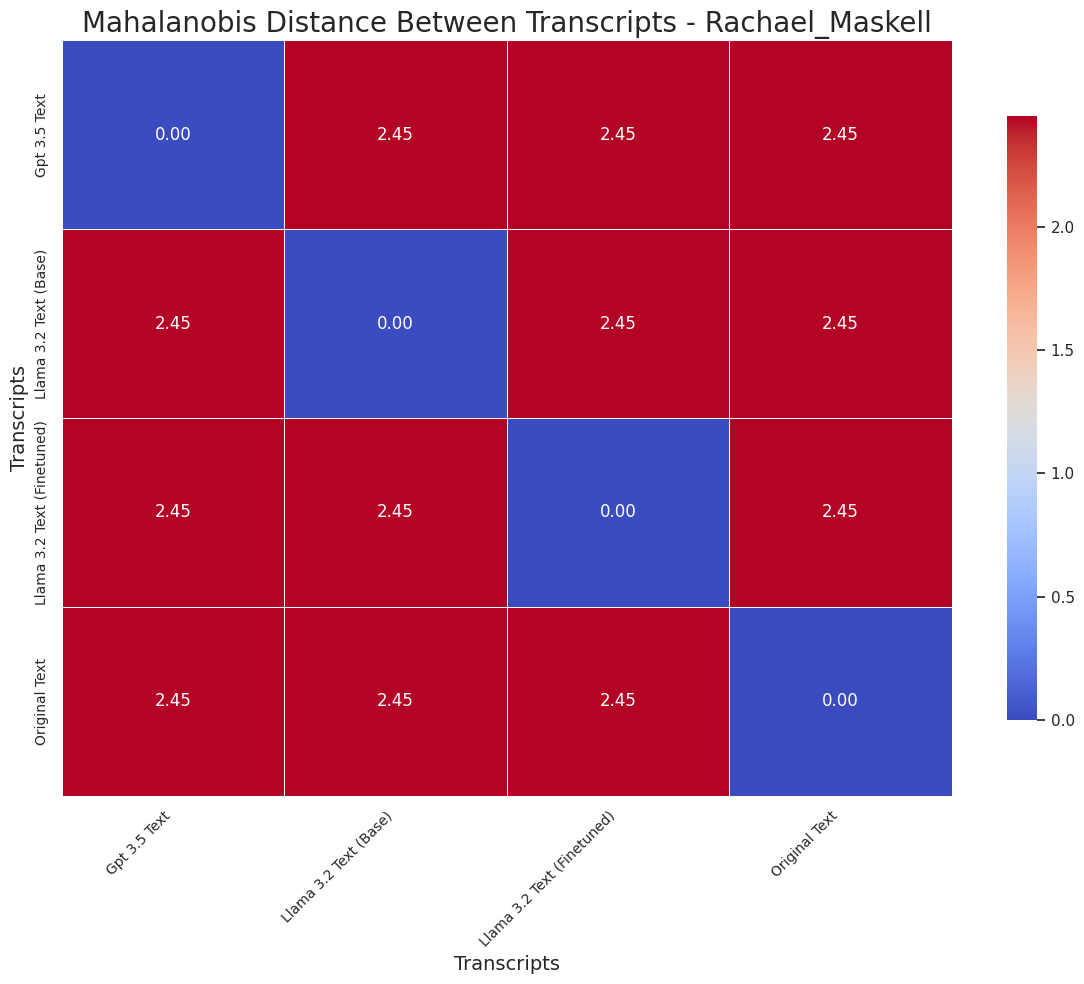

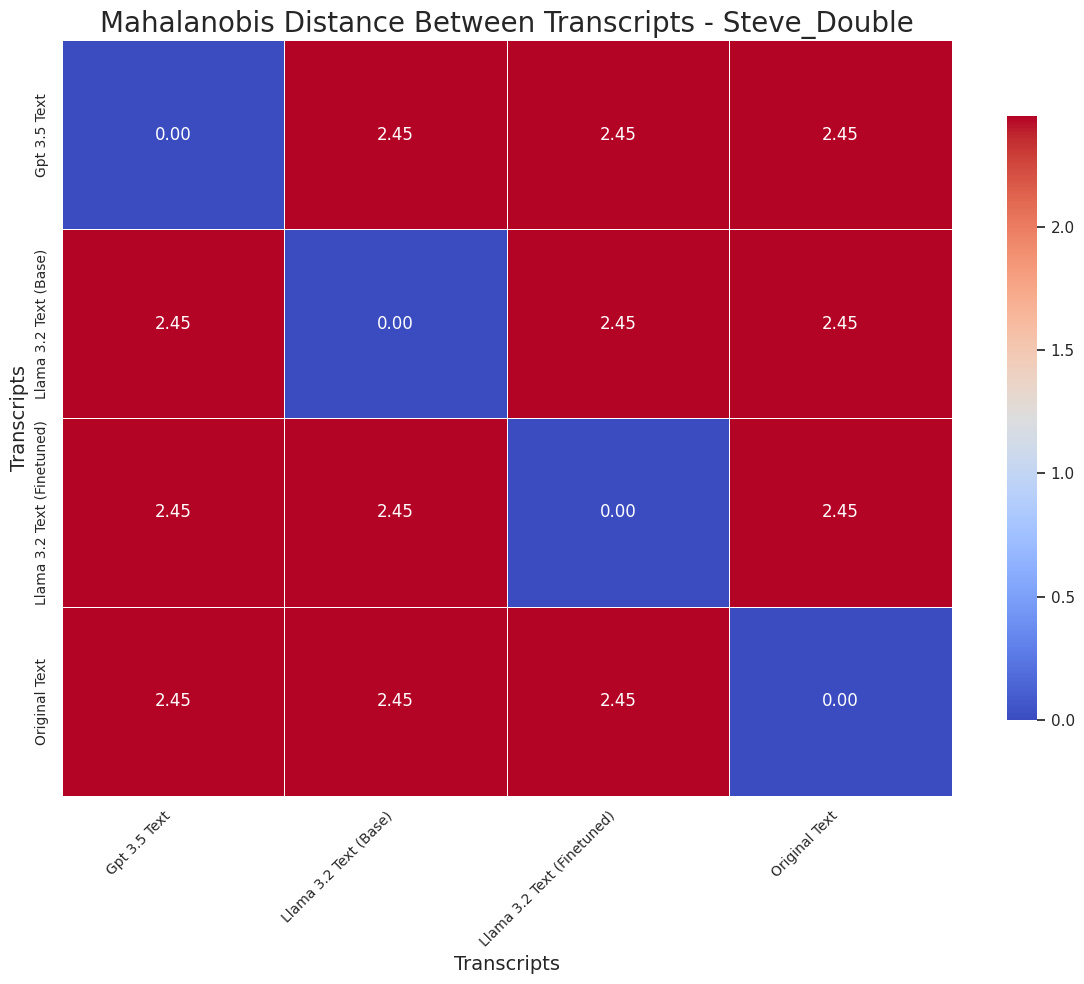

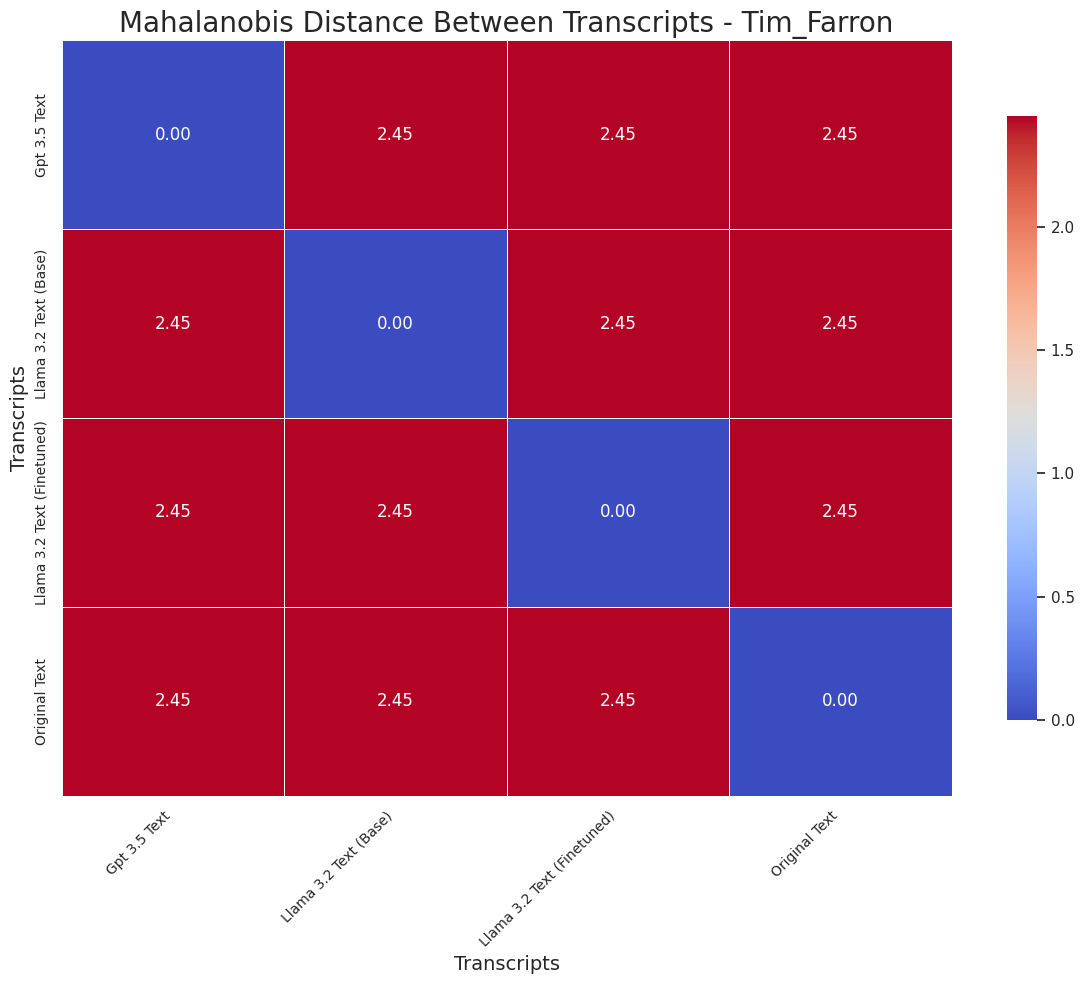

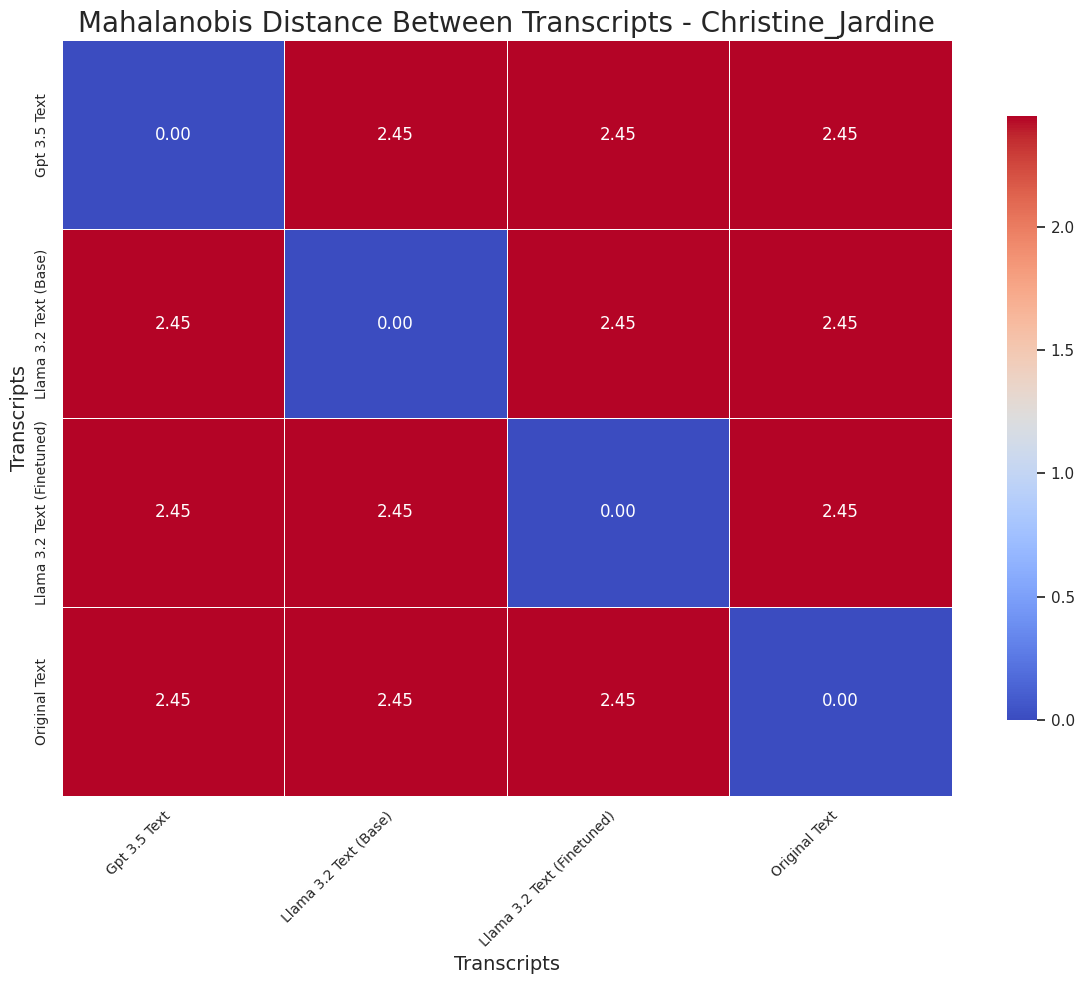

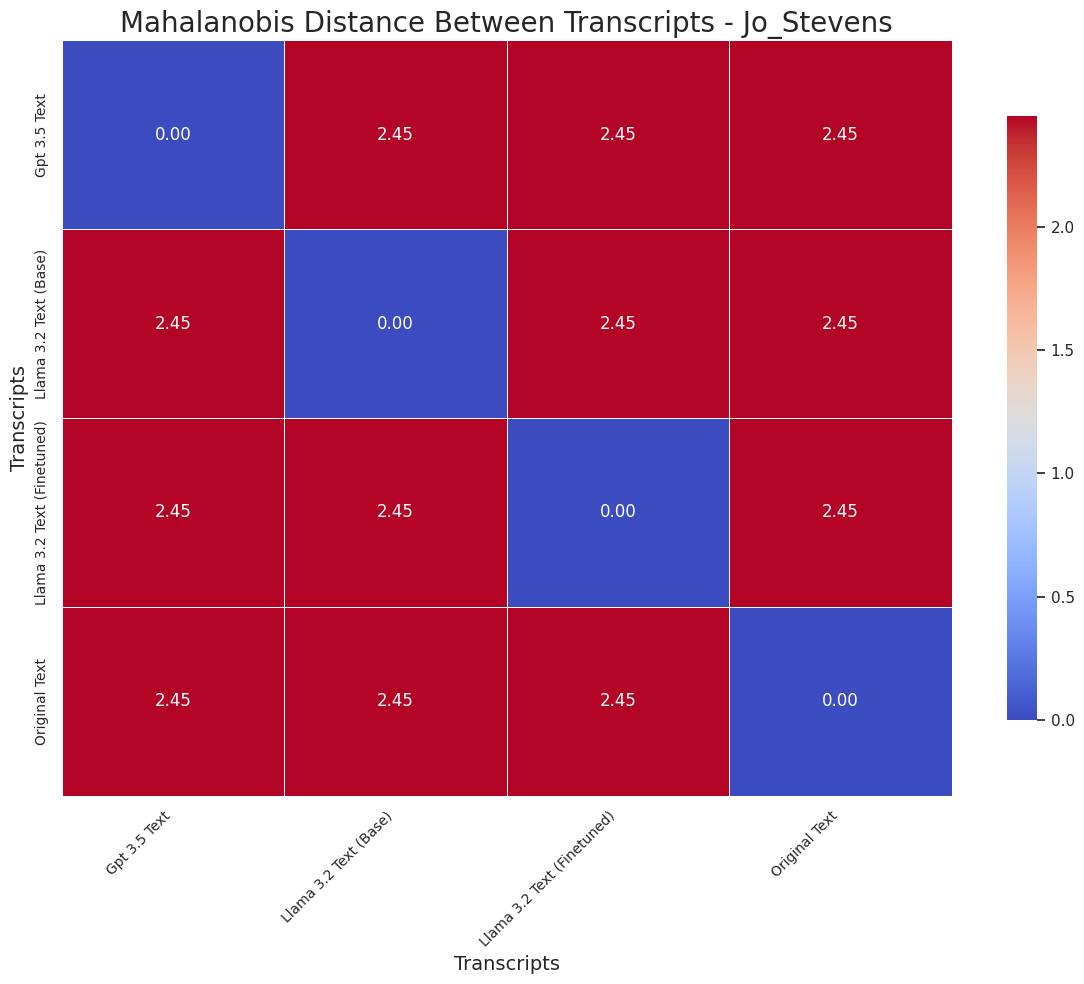

In [37]:
for speaker, df_subset in df_subsets.items():
    # Scale your data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_subset[liwc_features])

    # Compute the covariance matrix and its inverse (VI)
    cov_matrix = np.cov(df_scaled, rowvar=False)
    VI = pinv(cov_matrix)

    # Compute the Mahalanobis distance matrix
    mahalanobis_dist_matrix = cdist(df_scaled, df_scaled, metric='mahalanobis', VI=VI)

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        mahalanobis_dist_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm', 
        xticklabels=df_subset['TextID'], 
        yticklabels=df_subset['TextID'], 
        linewidths=.5, 
        cbar_kws={"shrink": .8}
    )
    plt.title(f'Mahalanobis Distance Between Transcripts - {speaker}', fontsize=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Transcripts', fontsize=14)
    plt.ylabel('Transcripts', fontsize=14)
    plt.tight_layout()

    plt.savefig(f'/kaggle/working/mahalanobis_distance_{speaker}.png')
    plt.show()

## LIWC Analysis - Debate Overall

In [38]:
# Load LIWC Results
df_LIWCresults_Models = pd.read_csv('/kaggle/input/debate-results/LIWC_analysis_debate_all_Models.csv')

# Clean df_LIWCresults_Speakers
df_LIWCresults_Models["Filename"] = df_LIWCresults_Models["Filename"].replace({
    "debate_transcript_original.txt": "Original Text",
    "debate_transcript_gpt.txt": "Gpt 3.5 Text",
    "debate_transcript_llama_base.txt": "Llama 3.2 Text (Base)",
    "debate_transcript_llama_finetuned.txt": "Llama 3.2 Text (Finetuned)",
})
#df_LIWCresults_Models = df_LIWCresults_Models.loc[:, (df_LIWCresults_Models != 0).any(axis=0)] # Remove columns with ALL 0
df_LIWCresults_Models.head()

,Filename,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,Gpt 3.5 Text,1,3186,85.34,94.15,35.06,99.00,19.43,32.89,83.43,...,0,0,11.90,5.05,3.83,0.13,0.00,0.91,1.98,0
1,Llama 3.2 Text (Base),1,6507,48.07,92.82,14.33,57.98,22.91,24.45,86.32,...,0,0,19.09,4.18,6.18,0.26,0.00,4.93,3.53,0
2,Llama 3.2 Text (Finetuned),1,6261,64.73,87.85,19.43,48.18,21.66,19.60,89.76,...,0,0,11.32,4.50,3.99,0.18,0.00,1.47,1.18,0
3,Original Text,1,4262,57.61,66.28,62.02,55.67,23.04,21.47,88.97,...,0,0,11.83,4.01,5.19,0.56,0.02,0.35,1.69,0


### Cosine Similarity

In [39]:
# Standardize the data
scaler = StandardScaler()
df_LIWCresults_Models_scaled = scaler.fit_transform(df_LIWCresults_Models[liwc_features]) 

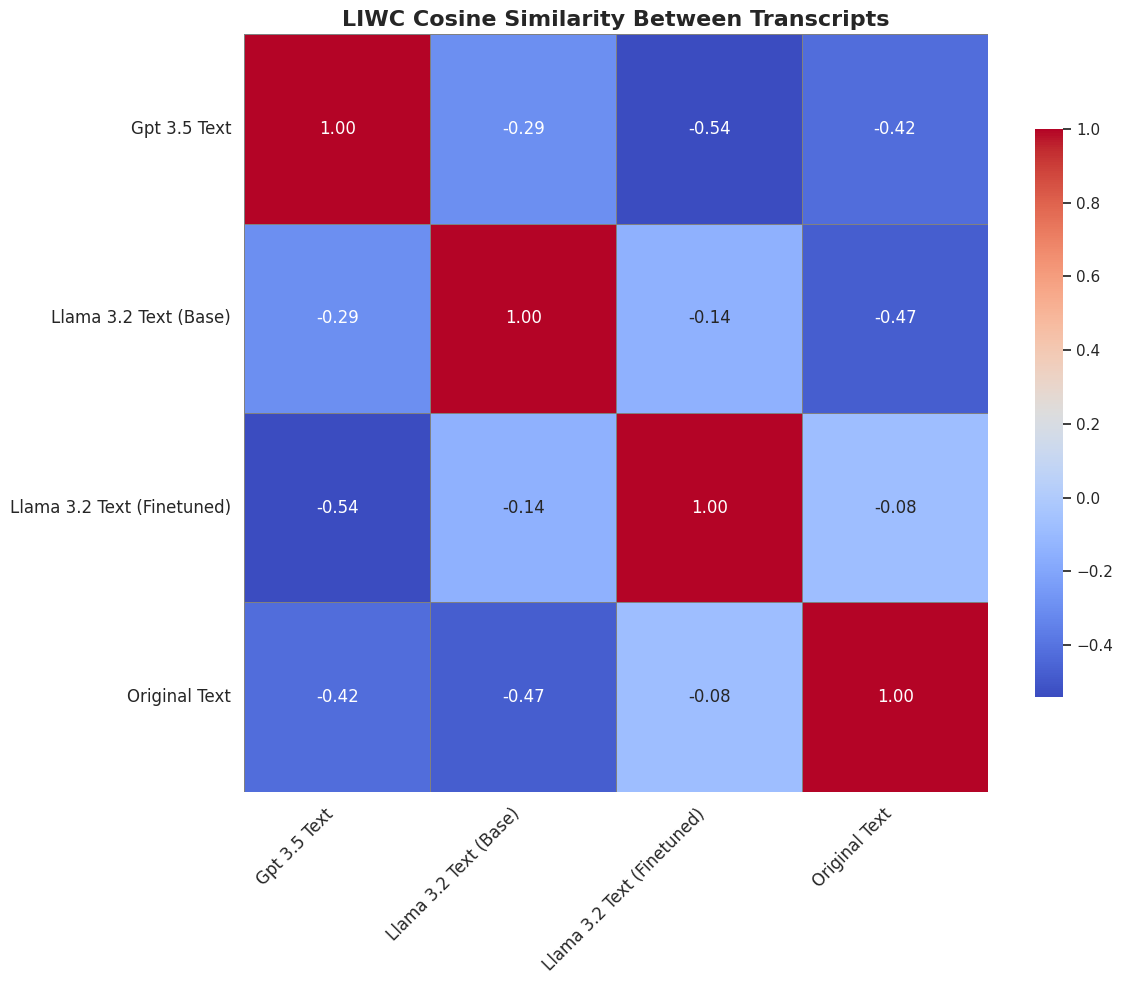

In [40]:
cosine_sim_matrix = cosine_similarity(df_LIWCresults_Models_scaled)

plt.figure(figsize=(12, 10))
sns.set(style="white")
heatmap = sns.heatmap(cosine_sim_matrix, 
                      annot=True, 
                      fmt=".2f", 
                      cmap='coolwarm', 
                      xticklabels=df_LIWCresults_Models['Filename'], 
                      yticklabels=df_LIWCresults_Models['Filename'], 
                      linewidths=0.5, 
                      linecolor='gray', 
                      cbar_kws={"shrink": 0.75})
plt.title('LIWC Cosine Similarity Between Transcripts', fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig('/kaggle/working/LIWC_cosine_heatmap.png', dpi=300)
plt.show()

### Mahalanobis Distance

In [41]:
# Calculate Mahalanobis distances
scaler = StandardScaler()
df_LIWCresults_Models_scaled = scaler.fit_transform(df_LIWCresults_Models[liwc_features])

cov_matrix = np.cov(df_LIWCresults_Models_scaled, rowvar=False)
inv_cov_matrix = pinv(cov_matrix) # Inverse the Matrix

def mahalanobis_distance(u, v, inv_cov_matrix):
    return mahalanobis(u, v, inv_cov_matrix)

n = df_LIWCresults_Models_scaled.shape[0] # Number of transcripts
mahalanobis_dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            mahalanobis_dist_matrix[i, j] = mahalanobis_distance(df_LIWCresults_Models_scaled[i], df_LIWCresults_Models_scaled[j], inv_cov_matrix)
mahalanobis_dist_matrix

array([[0.        , 2.44948974, 2.44948974, 2.44948974],
       [2.44948974, 0.        , 2.44948974, 2.44948974],
       [2.44948974, 2.44948974, 0.        , 2.44948974],
       [2.44948974, 2.44948974, 2.44948974, 0.        ]])

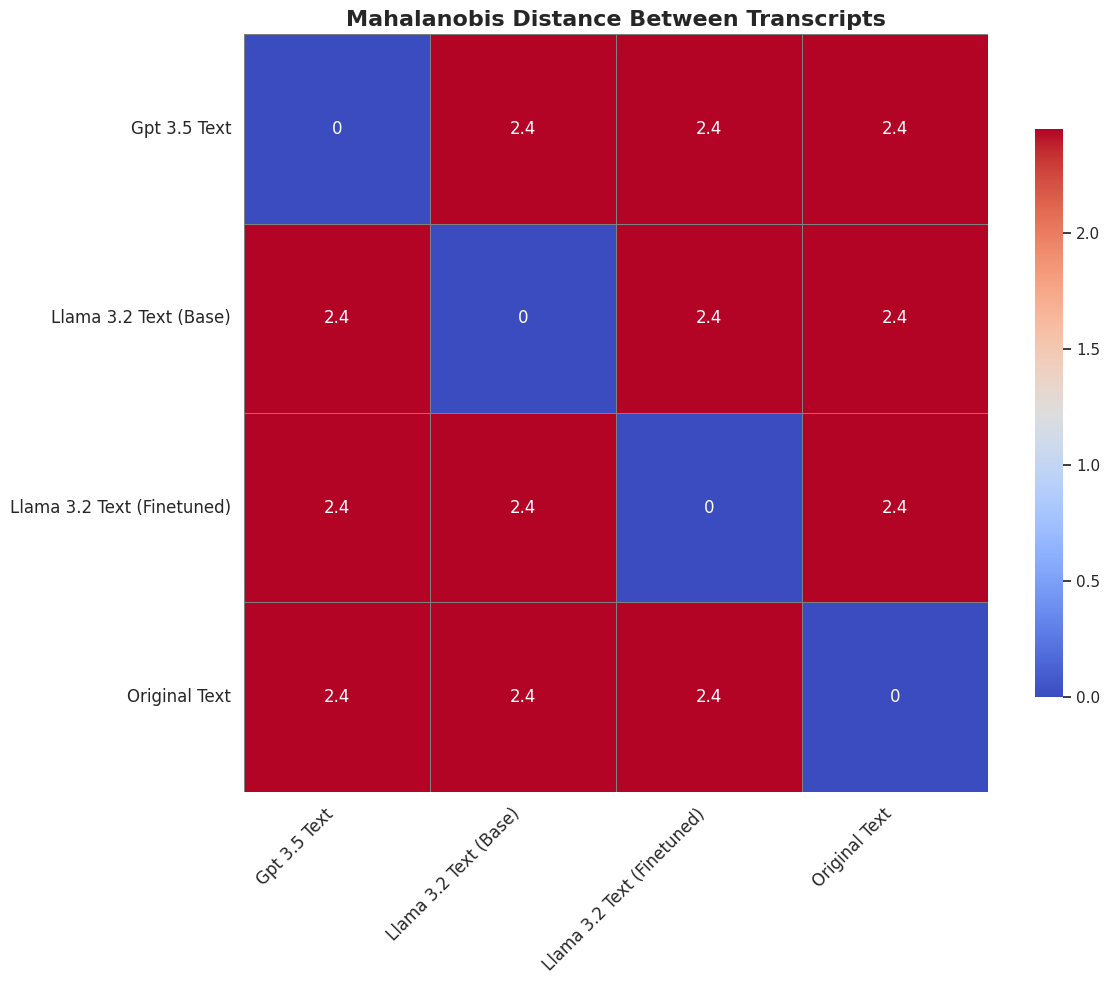

In [42]:
plt.figure(figsize=(12, 10))
sns.set(style="white")

# Create the heatmap
heatmap = sns.heatmap(mahalanobis_dist_matrix, annot=True, cmap='coolwarm', 
                      xticklabels=df_LIWCresults_Models['Filename'], 
                      yticklabels=df_LIWCresults_Models['Filename'],
                      linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.75})

# Add title and labels
plt.title('Mahalanobis Distance Between Transcripts', fontsize=16, weight='bold')

# Customize x-ticks and y-ticks
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Adjust layout
plt.tight_layout()


# Show the plot
plt.show()

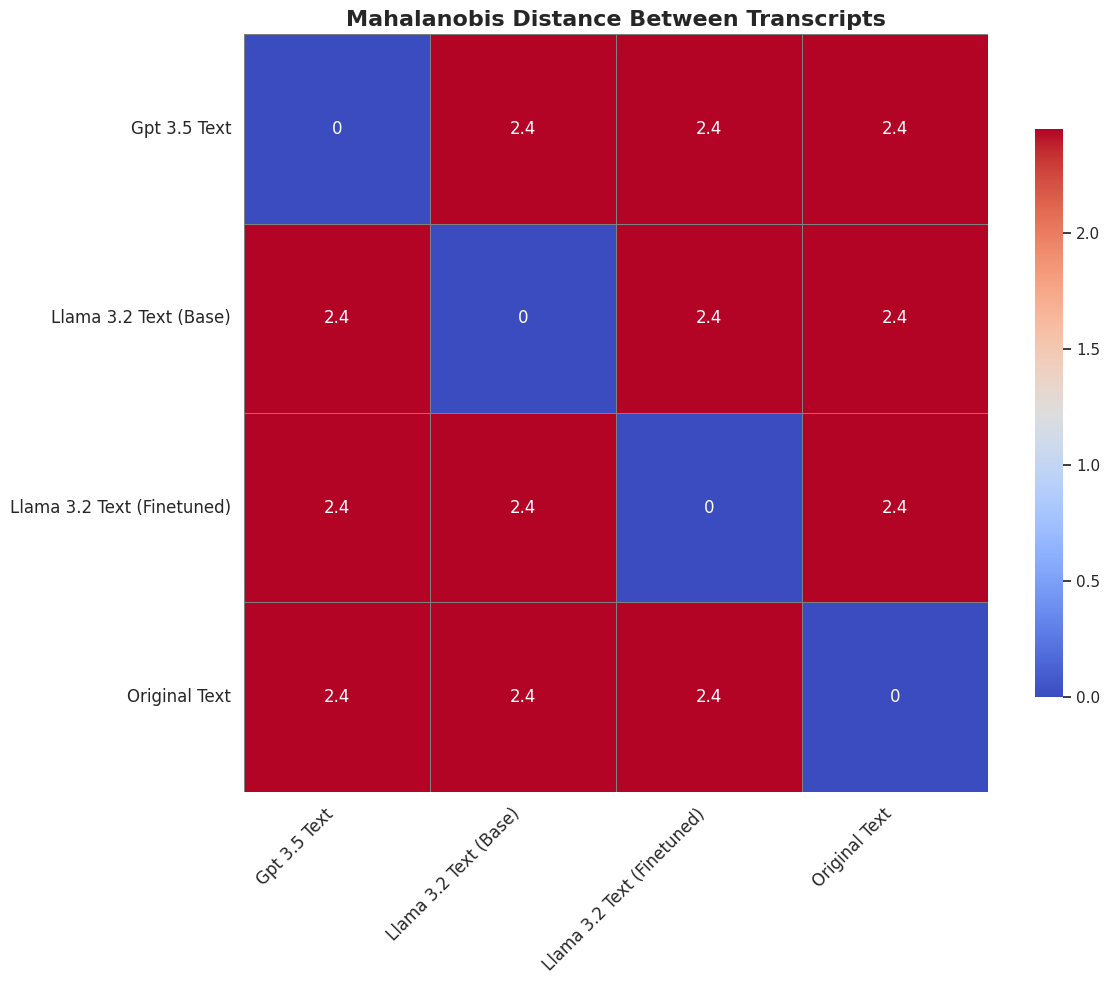

In [43]:
plt.figure(figsize=(12, 10))
sns.set(style="white")
heatmap = sns.heatmap(mahalanobis_dist_matrix, annot=True, cmap='coolwarm', 
                      xticklabels=df_LIWCresults_Models['Filename'], 
                      yticklabels=df_LIWCresults_Models['Filename'],
                      linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.75})

plt.title('Mahalanobis Distance Between Transcripts', fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig('/kaggle/working/LIWC_mahalanobis_heatmap.png', dpi=300)
plt.show()